In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [8]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv',encoding='latin1')

#### Rename columns for simplicity

In [9]:
df.rename(columns = {'emotion_in_tweet_is_directed_at': 'Product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion', 'tweet_text': 'Text'}, inplace= True)

In [10]:
df.drop(9092, inplace=True)
df.reset_index(drop=True, inplace=True)

#### LowerCase tweets for ease of use

In [15]:
df['Text'] = df['Text'].str.lower()
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '')
df['Text'] = df['Text'].str.split(' ')

In [18]:
df.dropna(subset=['Text'], inplace=True)

In [23]:
df['Product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: Product, dtype: int64

In [26]:
df['test'] = ''
df.fillna('na', inplace=True)

In [98]:
apple_keywords = ['apple', '#apple', 'ipad', '#ipad', '#iphone', 'iphone', 'itunes', '#itunes', 'ios', 'airpods', '#ios', '#airpods'
                 'iphones', 'ipads', 'apples', 'quotapple', 'quotipad', 'ipadquot', 'quotipads', 'ipadsquot', 'applequot', 'quotiphone', 'iphonequot', 'quotios', 'iosquot', 'quotiphones', 'iphonesquot', 'ipad2']
google_keywords = ['google', '#google', 'android', '#android', 'googles', 'androids', 'quotgoogle', 'googlequot', 'quotandroid', 'androidquot', 'quotandroids', 'androidsquot' ]

for ind, val in enumerate(df['Text']):
    if df['Product'].values[ind] == 'na':
        for y in val:
            if y in apple_keywords:
                df['test'].values[ind] = y
            elif y in google_keywords:
                df['test'].values[ind] = y
                
    else:
        df['test'].values[ind] = df['Product'].values[ind]




In [99]:
df['test'] = df['test'].map(lambda x: x.lower())
df['test'].unique()

array(['iphone', 'ipad or iphone app', 'ipad', 'google', 'android',
       'apple', 'android app', 'other google product or service',
       'itunes', '', 'quotgoogle', 'ipad2', 'googles', 'ipads',
       'applequot', 'ios', 'apples', 'ipadquot',
       'other apple product or service', 'quotipad', 'iosquot',
       'quotiphone', 'androidquot', 'googlequot', 'quotapple', 'androids',
       'iphonequot'], dtype=object)

In [188]:
df['test'] = df['test'].replace({'googles': 'google', 'apples': 'apple', 'androids': 'android','ipads': 'ipad', 'ipad2': 'ipad',
                                'quotgoogle': 'google', 'ipadquot': 'ipad', 'quotipad': 'ipad', 'androidquot': 'android', 'applequot': 'apple',
                               'googlequot': 'google', 'iphonequot': 'iphone', 'quotapple' : 'apple', 'iosquot': 'ios', 'quotiphone': 'iphone'})
df['test'].unique()

array(['iphone', 'ipad or iphone app', 'ipad', 'google', 'android',
       'apple', 'android app', 'other google product or service',
       'itunes', '', 'ios', 'other apple product or service'],
      dtype=object)

In [154]:
df['Emotion'].value_counts(normalize=True)

Neutral emotion     0.609724
Positive emotion    0.327577
Negative emotion    0.062699
Name: Emotion, dtype: float64

In [50]:
emotion_dict = {'No emotion toward brand or product' : 'Neutral emotion', "I can't tell": 'Neutral emotion', 'Positive emotion': 'Positive emotion',
               'Negative emotion': 'Negative emotion'}
df['Emotion'] = df['Emotion'].map(emotion_dict)

In [102]:
df['test'].value_counts()

ipad                               2274
google                             2045
apple                              1493
iphone                             1050
                                    840
ipad or iphone app                  470
android                             374
other google product or service     293
android app                          81
itunes                               64
quotgoogle                           41
other apple product or service       35
ipadquot                              7
ios                                   7
quotipad                              5
androidquot                           5
applequot                             2
googlequot                            1
iphonequot                            1
quotapple                             1
iosquot                               1
quotiphone                            1
Name: test, dtype: int64

In [189]:
def company_search(test):
    if test == 'iphone':
        return 'apple'
    elif test == 'apple':
        return 'apple'
    elif test == 'ipad':
        return 'apple'
    elif test == 'ipad or iphone app':
        return 'apple'
    elif test == 'itunes':
        return 'apple'
    elif test == 'other apple product or service':
        return 'apple'
    elif test == 'ios':
        return 'apple'
    elif test == 'ipadquot':
        return 'apple'
    elif test == 'applequot':
        return 'apple'
    elif test == 'iphonequot':
        return 'apple'
    elif test == 'quotiphone':
        return 'apple'
    elif test == 'iosquot':
        return 'apple'
    elif test =='quotipad':
        return 'apple'
    elif test == 'quotapple':
        return 'apple'
    elif test =='google':
        return 'google'
    elif test == 'android':
        return 'google'
    elif test == 'other google product or service':
        return 'google'
    elif test == 'android app':
        return 'google'
    elif test == 'quotgoogle':
        return 'google'
    elif test == 'googlequot':
        return 'google'
    elif test == 'androidquot':
        return 'google'
    else:
        return 'unknown'

In [190]:
df['company'] = df['test'].apply(company_search)

In [191]:
df['company'].value_counts()

apple      5411
google     2840
unknown     840
Name: company, dtype: int64

In [192]:
df_apple = df.loc[df['company'] == 'apple']
df_google = df.loc[df['company'] == 'google']

### Add Target values


In [194]:
df['Emotion'].value_counts()

Neutral emotion     5543
Positive emotion    2978
Negative emotion     570
Name: Emotion, dtype: int64

In [195]:
target_dict = {'Negative emotion': 0, 'Neutral emotion': 1, 'Positive emotion': 2}
df['target'] = df['Emotion'].map(target_dict)

In [196]:
df_pos = df.loc[df.target == 2]
df_neg = df.loc[df.target == 0]
df_neutral = df.loc[df.target == 1]

In [197]:
pos_words = []
neg_words = []
neutral_words = []

for list_ in df_pos['Text']:
    for word in list_:
        pos_words.append(word)

        
for list_ in df_neg['Text']:
    for word in list_:
        neg_words.append(word)
        
        
for list_ in df_neutral['Text']:
    for word in list_:
        neutral_words.append(word)
    

In [198]:
from collections import Counter
sw = stopwords.words('english')

In [199]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [200]:
pos_words = [lemma.lemmatize(word) for word in pos_words if word not in sw]
neg_words = [lemma.lemmatize(word) for word in neg_words if word not in sw]
neutral_words =  [lemma.lemmatize(word) for word in neutral_words if word not in sw]



In [201]:
pos_dict = Counter(pos_words)
neg_dict = Counter(neg_words)
neutral_dict = Counter(neutral_words)

In [202]:
pos_dict = dict(sorted(pos_dict.items(), key=lambda item: item[1], reverse=True))
neg_dict = dict(sorted(neg_dict.items(), key=lambda item: item[1], reverse=True))
neutral_dict = dict(sorted(neutral_dict.items(), key=lambda item: item[1], reverse=True))

In [203]:
pos_dict.pop('')
neg_dict.pop('')
neutral_dict.pop('')

2098

## Visualizations

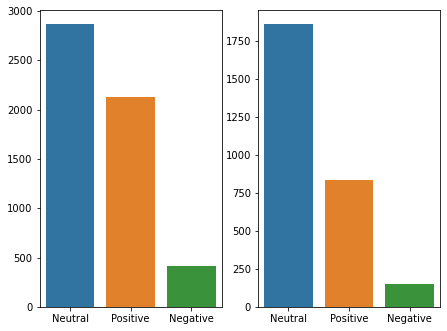

In [204]:
plt.figure(figsize=(15, 12))
ax1 = plt.subplot2grid(shape=(2,4), loc = (0,0))
ax2 = plt.subplot2grid(shape=(2,4), loc = (0,1))

sns.barplot(x = df_apple['Emotion'].value_counts().index,
           y = df_apple['Emotion'].value_counts().values,
           ax =ax1)
ax1.set_xticklabels(['Neutral', 'Positive', 'Negative'])

sns.barplot(x = df_google['Emotion'].value_counts().index,
           y = df_google['Emotion'].value_counts().values,
           ax = ax2)
ax2.set_xticklabels(['Neutral', 'Positive', 'Negative']);

<AxesSubplot:>

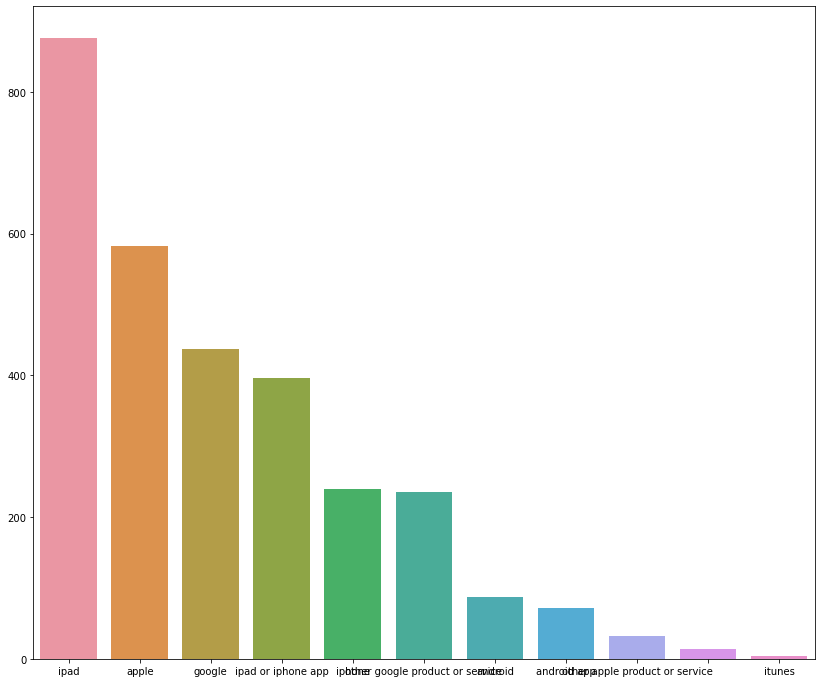

In [208]:
plt.figure(figsize=(14,12))

sns.barplot(x = df_pos['test'].value_counts().index,
           y = df_pos['test'].value_counts().values)

<AxesSubplot:>

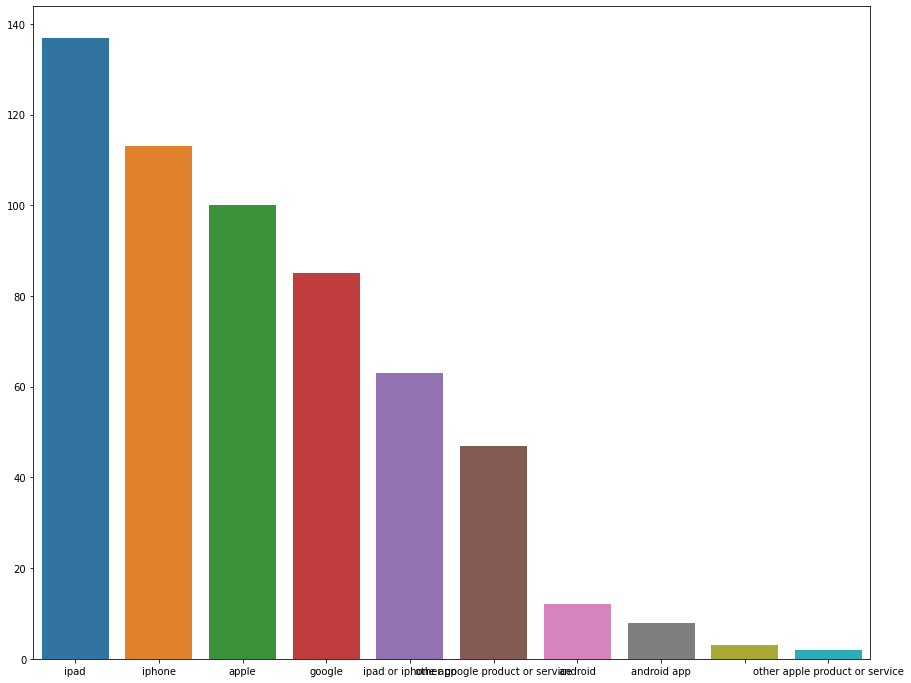

In [209]:
plt.figure(figsize=(15,12))

sns.barplot(x = df_neg['test'].value_counts().index,
           y = df_neg['test'].value_counts().values)

In [179]:
!pip install wordcloud

     |████████████████████████████████| 220 kB 858 kB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /Users/dillmedd/opt/anaconda3/envs/learn-env/bin/python3.8 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/w4/9n7mynxn3jlb2x_9chkh08980000gp/T/pip-install-otdd1pnz/wordcloud/setup.py'"'"'; __file__='"'"'/private/var/folders/w4/9n7mynxn3jlb2x_9chkh08980000gp/T/pip-install-otdd1pnz/wordcloud/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/w4/9n7mynxn3jlb2x_9chkh08980000gp/T/pip-wheel-ymj24lsv
       cwd: /private/var/folders/w4/9n7mynxn3jlb2x_9chkh08980000gp/T/pip-install-otdd1pnz/wordcloud/
  Complete output (65 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.8
  creating build/lib.macosx-10.9

Failed to build wordcloud
    Running setup.py install for wordcloud ... error
    ERROR: Command errored out with exit status 1:
     command: /Users/dillmedd/opt/anaconda3/envs/learn-env/bin/python3.8 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/w4/9n7mynxn3jlb2x_9chkh08980000gp/T/pip-install-otdd1pnz/wordcloud/setup.py'"'"'; __file__='"'"'/private/var/folders/w4/9n7mynxn3jlb2x_9chkh08980000gp/T/pip-install-otdd1pnz/wordcloud/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/w4/9n7mynxn3jlb2x_9chkh08980000gp/T/pip-record-o6ooollt/install-record.txt --single-version-externally-managed --compile --install-headers /Users/dillmedd/opt/anaconda3/envs/learn-env/include/python3.8/wordcloud
         cwd: /private/var/folders/w4/9n7mynxn3jlb2x_9chkh08980000gp/T/pip-install-otdd1pnz/wordcloud/
    

In [180]:
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'wordcloud'

### Models

In [215]:
from sklearn.model_selection import train_test_split

In [214]:
X = df.Text
y = df.target

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

X_train = X_train.str.join(' ')
X_test = X_test.str.join(' ')

In [237]:
tfidf = TfidfVectorizer(stop_words=sw, ngram_range = (1,3))
X_train_vec = tfidf.fit_transform(X_train)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(tfidf.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [238]:
X_val_vec = tfidf.transform(X_test)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_test.index, inplace=True)

In [239]:
df_vec = pd.DataFrame(X.toarray(), columns = tfidf.get_feature_names())
df_vec

ValueError: Shape of passed values is (6818, 9479), indices imply (6818, 87335)

In [241]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
y_hat = mnb.predict(X_train_vec)

In [242]:
print(confusion_matrix(y_train, y_hat))

[[   9  409   10]
 [   0 4144   13]
 [   0  792 1441]]


In [243]:
print(accuracy_score(y_train, y_hat))

0.8204752126723379
